In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as pl 
import seaborn as sns 
import pickle

from tqdm import tqdm

from src.utils.windows import sliding_window_rect

import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from keras.layers import Input, Conv2D, Dropout, BatchNormalization, \
    AveragePooling2D, GlobalAveragePooling2D, Activation, Lambda, ZeroPadding1D, \
    MaxPooling2D, GlobalMaxPooling2D, Flatten, Dense, Concatenate, Reshape, \
    Conv2DTranspose, UpSampling2D
    
from keras.models import Model
from torch import nn, optim
from keras import backend as K

sns.set_style('darkgrid')
sns.set_context('paper')

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def eulerAnglesToRotationMatrix(theta) :
    ones = np.ones(theta.shape[0])
    zero = np.zeros(theta.shape[0])
    
    R_x = np.asarray([
        [ones, zero, zero],
        [zero, np.cos(theta[:, 0]), -np.sin(theta[:, 0])], 
        [zero, np.sin(theta[:, 0]),  np.cos(theta[:, 0])], 
    ]).transpose(2, 0, 1)

    R_y = np.asarray([
        [np.cos(theta[:, 1]), zero, np.sin(theta[:, 1])],
        [zero, ones, zero],
        [-np.sin(theta[:, 1]), zero, np.cos(theta[:, 1])]
    ]).transpose(2, 0, 1)
                 
    R_z = np.array([
        [np.cos(theta[:, 2]), -np.sin(theta[:, 2]), zero],
        [np.sin(theta[:, 2]), np.cos(theta[:, 2]), zero],
        [zero, zero, ones]
    ]).transpose(2, 0, 1)
                     
    R = np.einsum('abc,acd->abd', R_z, np.einsum('abc,acd->abd', R_y, R_x))
#     R_old = np.dot(R_z[0], np.dot(R_y[0], R_x[0]))
#     assert np.allclose(R[0], np.dot(R_z[0], np.dot(R_y[0], R_x[0])))
 
    return R

In [3]:
# def load_modality(modality, n_rotations=0):
#     accel = pickle.load(open(f'{modality}-waist-body.pkl', 'rb'))
#     index = pickle.load(open('index.pkl', 'rb'))
#     label = pickle.load(open('label.pkl', 'rb'))

#     inds = (
#         (label.track_0.apply(lambda ll: 'walk' in ll)) &
#         (index.subject == 2)
#     )

#     accel, index, label = accel[inds], index[inds], label[inds]

# #     rng = np.random.RandomState(1234)
#     accel = sliding_window_rect(accel.values, 32, 7).transpose(0, 2, 1)

#     accel_rot = []

# #     for _ in tqdm(range(100), total=100):
# #         R = eulerAnglesToRotationMatrix(rng.uniform(-np.pi, np.pi, (accel.shape[0], 3)))
# #         rots = np.einsum('ijk,ijl->ijk', accel, R)
# #         accel_rot.extend(np.concatenate(rots, axis=0))
#     accel_rot = np.asarray(accel_rot)
#     norms = np.linalg.norm(accel_rot, axis=1)
#     norm_ord = np.argsort(-norms)
#     accel = accel_rot[:, :]
#     print(accel.shape)

#     norms = np.linalg.norm(accel, axis=1, keepdims=True)
#     inds = np.argsort(-norms.ravel(), axis=0)

#     accel = accel[inds[:100000]]

#     inds = rng.permutation(accel.shape[0])
#     accel = accel[inds][:, None, :]

#     print(accel.shape)

(8436, 32) (8436, 32)


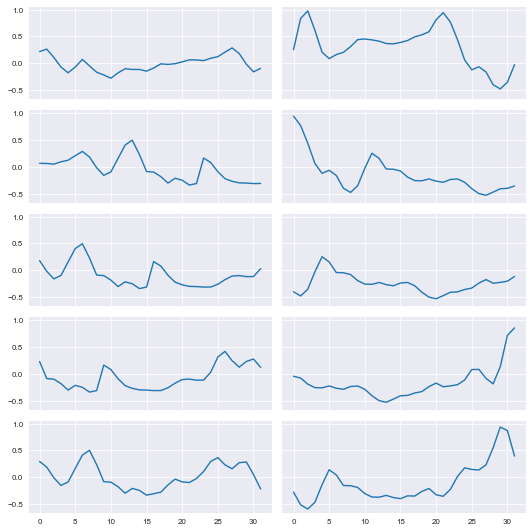

In [4]:
def load_modality(modality, n_rotations=0):
    data = pickle.load(open(f'{modality}-waist-body.pkl', 'rb'))
    index = pickle.load(open('index.pkl', 'rb'))
    label = pickle.load(open('label.pkl', 'rb'))

    inds = (
        (label.track_0.apply(lambda ll: 'walk' in ll)) &
        (index.subject == 2)
    )

    data, index, label = data[inds], index[inds], label[inds]
    data = sliding_window_rect(data.values, 32, 7).transpose(0, 2, 1)

    data = np.concatenate(data, 0)

    norms = np.linalg.norm(data, axis=1, keepdims=True)
    inds = np.argsort(-norms.ravel(), axis=0)

    return data, inds

accel, accel_inds = load_modality('accel')
gyro, gyro_inds = load_modality('gyro')
print(accel.shape, gyro.shape)

N = 2000
inds = np.sort(list(set(accel_inds[:N]) | set(gyro_inds[:N])))
accel, gyro = accel[inds], gyro[inds]

N = 5
fig, axes = pl.subplots(N, 2, sharex=True, sharey=True, figsize=(7.5, 1.5 * N))
for ii, (ax0, ax1) in enumerate(axes): 
    ax0.plot(accel[ii])
    ax1.plot(gyro[ii])
pl.tight_layout()

(2964, 32)

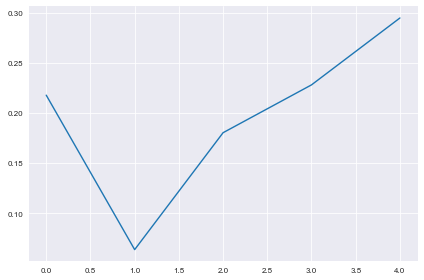

In [8]:
fig, ax = pl.subplots(1, 1, sharex=True, sharey=False) 

ax.plot(accel[:5, 0].T)

pl.tight_layout()

accel_torch = torch.from_numpy(accel).float()

accel.shape

In [9]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
    
class Identity(nn.Module): 
    def forward(self, x): 
        return x
    
    
class UnFlatten(nn.Module):
    def __init__(self, shape_func): 
        super(UnFlatten, self).__init__()
        self.shape_func = shape_func
        
    def forward(self, input, size=64):
        return input.view(self.shape_func(input.shape))
    
    
    
class ConvUnit(nn.Sequential): 
    def __init__(self, in_channels, out_channels, stride, padding=0, kernel_size=5): 
        super(ConvUnit, self).__init__(
            nn.Conv1d(
                in_channels=in_channels, 
                out_channels=out_channels, 
                kernel_size=kernel_size, 
                padding=padding, 
            ),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(), 
            nn.MaxPool1d(stride), 
        )
        
        
        
class ConvTransposeUnit(nn.Sequential): 
    def __init__(self, in_channels, out_channels, stride, padding=0, output_padding=0, kernel_size=5, last=False): 
        super(ConvTransposeUnit, self).__init__(
            nn.ConvTranspose1d(
                in_channels=in_channels, 
                out_channels=out_channels, 
                kernel_size=kernel_size, 
                stride=stride,
                output_padding=output_padding,
                padding=padding,
            ),
            Identity() if last else nn.ReLU() , 
        )
        
def print_sizes(vae, x): 
    x = torch.Tensor(x)
    print('\nencoding')
    print(x.shape)
    for layer in vae.encoder.children(): 
        x = layer(x)
        print(x.shape)
        
    print('\nlatent')
    mu, log_var = vae.mu(x), vae.log_var(x)
    print(mu.shape, log_var.shape)
    
    print('\ncode')
    z = vae.reparameterise(mu, log_var)
    print(z.shape)
    
    print('\nlin')
    x = vae.lin(z)
    print(x.shape)
    
    print('\ndecoding')
    print(x.shape)
    for layer in vae.decoder.children(): 
        x = layer(x)
        print(x.shape)
        
        
class VAE(nn.Module): 
    def __init__(self, z_hidden): 
        super(VAE, self).__init__() 
        
        sizes = [
            4, 8, 16, 32, 64 
        ]
        
        sizes = [16] * len(sizes)
        
        k = 3
        p = 1
        op = 1
        
        self.encoder = nn.Sequential(
            ConvUnit(1,        sizes[0], stride=2, padding=p, kernel_size=k),
            ConvUnit(sizes[0], sizes[1], stride=2, padding=p, kernel_size=k),
            ConvUnit(sizes[1], sizes[2], stride=2, padding=p, kernel_size=k),
            ConvUnit(sizes[2], sizes[3], stride=2, padding=p, kernel_size=k),
            ConvUnit(sizes[3], sizes[4], stride=2, padding=p, kernel_size=k),
            Flatten(),
        )
        
        self.decoder = nn.Sequential(
            UnFlatten(lambda shape: (shape[0], sizes[-1], 1)),
            ConvTransposeUnit(sizes[4], sizes[3], stride=2, padding=p, kernel_size=k, output_padding=op),
            ConvTransposeUnit(sizes[3], sizes[2], stride=2, padding=p, kernel_size=k, output_padding=op),
            ConvTransposeUnit(sizes[2], sizes[1], stride=2, padding=p, kernel_size=k, output_padding=op),
            ConvTransposeUnit(sizes[1], sizes[0], stride=2, padding=p, kernel_size=k, output_padding=op),
            ConvTransposeUnit(sizes[0],        1, stride=2, padding=p, kernel_size=k, output_padding=op, last=True),
        )
        
        self.mu = nn.Linear(sizes[-1], z_hidden)
        self.log_var = nn.Linear(sizes[-1], z_hidden)
        
        self.lin = nn.Linear(z_hidden, sizes[-1])
        
        # print_sizes(self, accel_torch[:100])
        
    def encode(self, x): 
        z = self.encoder(x) 
        mu = self.mu(z)
        log_var = self.log_var(z)
        z_hat = self.reparameterise(mu, log_var)
        return z, mu, log_var, z_hat
    
    def reparameterise(self, mu, log_var): 
        std = F.softplus(log_var) 
        eps = Variable(std.data.new(std.size()).normal_())
        return eps.mul(std).add_(mu)
    
    def decode(self, x): 
        x = self.lin(x)
        return self.decoder(x)
    
    def forward(self, x): 
        z, mu, log_var, z_hat = self.encode(x)
        x_hat = self.decode(z_hat)
        return mu, log_var, z_hat, x_hat
        
    def kl_loss(self, mu, log_var): 
        loss = -0.5 * (1 + log_var - mu.pow(2) - log_var.exp()) 
        return loss.sum(1).mean() 
    
    def mse_loss(self, x, x_hat): 
        loss = (x - x_hat).pow(2)
        return loss.sum((1, 2)).mean()
    
    def loss_func(self, x, x_hat, mu, log_var): 
        return (
            self.mse_loss(x, x_hat),
            self.kl_loss(mu, log_var) 
        )
        

class MultiSourceVAE(object): 
    def __init__(self, z_hidden): 
        self.accel = VAE(z_hidden=z_hidden)
        # self.gyro = VAE(z_hidden=z_hidden) 
    
    def forward(self, accel, gyro): 
        mu, log_var, zz, accel_hat = self.accel.forward(accel)
        accel_from_accel = self.accel.decode(zz)
        gyro_from_accel = self.gyro.decode(zz)
        
        return mu, log_var, zz, accel_from_accel, gyro_from_accel
        
    def loss(self, accel, gyro, mu, log_var, zz, accel_from_accel, gyro_from_accel):
        return sum((
            (accel - accel_from_accel).pow(2).sum((1, 2)).mean(), 
            (gyro - gyro_from_accel).pow(2).sum((1, 2)).mean(), 
        ))
#             (accel - accel_from_gyro).pow(2).sum((1, 2)).mean(), 
#             (gyro - gyro_from_accel).pow(2).sum((1, 2)).mean(), 
#     , (z_a - z_g).sum(1).mean()

vae = MultiSourceVAE(16)

In [ ]:
def train(epoch, total, with_mse=True, with_kl=False, beta=1):
    vae.train()
    train_loss = 0
    for batch_idx, x in enumerate(data_loader):
        adam.zero_grad()
        mu, log_var, zz, accel_from_accel, gyro_from_accel = vae.forward(x)
        mse_loss, kl_loss = vae.loss_func(x, x_hat, mu, log_var)
        losses = []
        if with_mse: 
            losses.append(mse_loss)
        if with_kl:
            losses.append(kl_loss / beta)
        assert len(losses)
        loss = sum(losses)
        loss.backward()
        train_loss += loss.item()
        adam.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f} MSE: {:.6f} KL: {:.6f}'.format(
                epoch, total, batch_idx * len(x), len(data_loader.dataset),
                100. * batch_idx / len(data_loader),
                loss, mse_loss, kl_loss))
    print('====> Epoch: {}/{} Average loss: {:.4f}\n'.format(
          epoch, total, train_loss / len(data_loader.dataset)))
    
N = 10
beta = 100
start = 0

data_loader = torch.utils.data.DataLoader(accel_torch, batch_size=100, shuffle=True)
adam = optim.Adam(vae.parameters(), 1e-3)

for ii in range(start, N // 3): 
    train(ii + 1, start + N // 3, with_mse=True, with_kl=False, beta=beta)

for ii in range(N): 
    train(ii + 1, start + N, with_mse=True, with_kl=False, beta=beta)
    
adam = optim.Adam(vae.parameters(), 1e-4)
for ii in range(N * 2): 
    train(ii + 1, start + N * 2, with_mse=True, with_kl=True, beta=beta)
    
torch.save(vae.state_dict(), f'{modality}.torch')

In [ ]:
x = accel_torch[:1000]
mu, log_var, x_hat = vae.forward(x)

x_np = np.asarray(x.tolist())
mu_np = np.asarray(mu.tolist())
x_hat_np = np.asarray(x_hat.tolist())

In [ ]:
N = 10

fig, axes = pl.subplots(N, 3, sharex=True, sharey=True, figsize=(7.5, 1.5 * N)) 

for ii, (ind_0, ind_1) in enumerate(np.random.randint(0, x_np.shape[0], (N, 2))):
    mu_0 = mu[[ind_0]]
    mu_1 = mu[[ind_1]]

    axes[ii, 0].plot(x_np[ind_0].ravel())
    axes[ii, 0].plot(np.asarray(vae.decode(mu_0).tolist()).ravel())
    for ai, alpha in enumerate(np.linspace(0, 1, 11)): 
        recon = vae.decode(alpha * mu_0 + (1 - alpha) * mu_1)
        axes[ii, 1].plot(np.asarray(recon.tolist()).ravel(), 'k', lw=0.5)
    axes[ii, 2].plot(x_np[ind_1].ravel())
    axes[ii, 2].plot(np.asarray(vae.decode(mu_1).tolist()).ravel())
pl.tight_layout()

In [ ]:
fig, axes = pl.subplots(5, 5, sharex=True, sharey=True, figsize=(10, 10))
inds = np.random.randint(0, x_np.shape[0], np.prod(axes.shape)).reshape(axes.shape)
for ii in range(axes.shape[0]):
    for jj in range(axes.shape[1]):
        axes[ii, jj].plot(x_np[inds[ii, jj]].T)
        axes[ii, jj].plot(x_hat_np[inds[ii, jj]].T)
pl.tight_layout()